## Installing Dependences and imports

In [1]:
!pip install -q kaggle datasets spacy transformers
!python -m spacy download en_core_web_lg
!pip install fastcoref -q
!pip install negspacy -q
!pip install flair
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import kagglehub
import spacy
from tqdm.auto import tqdm
from tqdm import tqdm
from negspacy.negation import Negex
from negspacy.termsets import termset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from fastcoref import spacy_component
from flair.models import SequenceTagger
from flair.data import Sentence
from sklearn.decomposition import PCA
from google.colab import drive
from collections import Counter
from spacy.matcher import Matcher
from datasets import load_dataset
from google.colab import files

## Setting up Kaggle API

In [4]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (2).json to kaggle (2).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## Loading Dataset 1 (Hugging face)

In [5]:
!wget https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/resolve/main/raw/Cognitive_distortions.csv

# Load and structure the data
df1 = pd.read_csv("Cognitive_distortions.csv")
df1 = df1.rename(columns={
    'Text': 'Patient Question',
    'Label': 'Dominant Distortion'
})
df1.insert(1, "Distorted part", value=np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value=np.nan)

df1.head()

--2025-06-23 21:38:49--  https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/resolve/main/raw/Cognitive_distortions.csv
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021440 (998K) [text/plain]
Saving to: ‘Cognitive_distortions.csv’

Cognitive_distortio 100%[===================>] 997.50K  --.-KB/s    in 0.07s   

2025-06-23 21:38:49 (14.8 MB/s) - ‘Cognitive_distortions.csv’ saved [1021440/1021440]



,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN


In [6]:
for col in ["Distorted part", "Dominant Distortion", "Secondary Distortion (Optional)"]:
  print(f"Unique values in '{col}':")
  if col in df1.columns:
    print(df1[col].unique())
  else:
    print(f"Column '{col}' not found in df1.")
  print("-" * 30)

Unique values in 'Distorted part':
[nan]
------------------------------
Unique values in 'Dominant Distortion':
['Distortion' 'No Distortion']
------------------------------
Unique values in 'Secondary Distortion (Optional)':
[nan]
------------------------------


## Load Dataset 2 (Kaggle)

In [7]:
multiclass_dataset_path = kagglehub.dataset_download(
    "sagarikashreevastava/cognitive-distortion-detetction-dataset"
)
print("Path to dataset files:", multiclass_dataset_path)
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

100%|██████████| 4.76M/4.76M [00:00<00:00, 64.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset/versions/1


### Cleaning & Structuring df2

In [8]:
df2 = pd.read_csv(multiclass_dataset_file_path)
df2 = df2.drop('Id_Number', axis=1) # deleting column with id
df2

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


## Concatenate into df3

In [10]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [15]:
for col in ["Distorted part", "Dominant Distortion", "Secondary Distortion (Optional)"]:
  print(f"Unique values in '{col}':")
  if col in df3.columns:
    print(df3[col].unique())
  else:
    print(f"Column '{col}' not found in df1.")
  print("-" * 30)

Unique values in 'Distorted part':
[nan
 'The voice are always fimilar (someone she knows) Im very concerned about this and hope it has nothing to do with my pregnancy while on active duty.'
 'I feel trapped inside my disgusting self and like I’m willing to do anything to escape it.I’m just afraid sometimes that since I’m not really thinking during these times that I might do something to myself–especially since I think during these times that I don’t deserve to get help or that I’m not worth disturbing people by calling them.'
 ...
 'However, I am not happy, at the least only half of me is happy at a time. I feel as though I am having two different feelings. One is of an extrovert, and the other is of an introvert. I do not want to be alone but even so I want to be isolated.'
 'Now I am at university my peers around me all have social lives and boyfriends and so it hurts more now. I tried making friends but seem to have a perpetual block for the last 10 years.'
 'He claims he’s severe

In [21]:
df3 = pd.concat([df1.drop(columns=["Distorted part", "Secondary Distortion (Optional)"]), df2], ignore_index=True)
df3 = df3.rename(columns={"Patient Question": "text"})
df3 = df3.reset_index().rename(columns={"index": "id"})

print(" Dataset 1 and Dataset 2 loaded and combined into df3.")
print(df3.head())

 Dataset 1 and Dataset 2 loaded and combined into df3.
   id                                               text Dominant Distortion  \
0   0      I'm such a failure I never do anything right.          Distortion   
1   1       Nobody likes me because I'm not interesting.          Distortion   
2   2   I can't try new things because I'll just mess...          Distortion   
3   3   My boss didn't say 'good morning' she must be...          Distortion   
4   4   My friend didn't invite me to the party I mus...          Distortion   

  Distorted part Secondary Distortion (Optional)  
0            NaN                             NaN  
1            NaN                             NaN  
2            NaN                             NaN  
3            NaN                             NaN  
4            NaN                             NaN  


In [23]:
# prompt: Renmae 'Distortion' in dominant disrotion column in df3

df3['Dominant Distortion'] = df3['Dominant Distortion'].replace('Distortion', 'General Distortion')

In [24]:
# prompt: dominant distortion unique values

print(df3['Dominant Distortion'].unique())

['General Distortion' 'No Distortion' 'Personalization' 'Labeling'
 'Fortune-telling' 'Magnification' 'Mind Reading'
 'All-or-nothing thinking' 'Overgeneralization' 'Mental filter'
 'Emotional Reasoning' 'Should statements']


#### Installing and Loading fastcoref


In [25]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    print(" GPU is available")
else:
  print("CPU")

 GPU is available


#### Applying Coref Resolution to Texts

In [26]:
from fastcoref import FCoref
import spacy

# Load spaCy's lg model (for dependency parsing/NER)
nlp = spacy.load("en_core_web_lg")

coref_model = FCoref(device='cuda')

# Process data
predictions = coref_model.predict(df3["text"].tolist())
resolved_texts = [p.text for p in predictions]
df3["resolved_text"] = resolved_texts

docs = list(nlp.pipe(df3["resolved_text"], batch_size=16))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

Map:   0%|          | 0/6057 [00:00<?, ? examples/s]

Inference:   0%|          | 0/6057 [00:00<?, ?it/s]

In [32]:
texts = df3["resolved_text"].tolist()

#### Manually Verifying Coref Accuracy

In [33]:
sample_check = df3[["text", "resolved_text"]].sample(10)
display(sample_check)

,text,resolved_text
1033,without too much detail I am a child from divo...,without too much detail I am a child from divo...
5937,"Hi, I am 14 years old, and I have had problems...","Hi, I am 14 years old, and I have had problems..."
1057,My girlfriend’s male best friend has been slee...,My girlfriend’s male best friend has been slee...
2519,I was so disapointed on this celebrity childho...,I was so disapointed on this celebrity childho...
4553,I’m currently in a very happy and otherwise he...,I’m currently in a very happy and otherwise he...
4416,From the U.S.: I’m 20. I just got married but ...,From the U.S.: I’m 20. I just got married but ...
3494,My girlfriend is undiagnosed However displays ...,My girlfriend is undiagnosed However displays ...
576,I don't get as many calls as my sister I must...,I don't get as many calls as my sister I must...
2801,for a long time now i have felt empty and bore...,for a long time now i have felt empty and bore...
2873,I do know she’s better not knowing every detai...,I do know she’s better not knowing every detai...


#Handling Negation in Relationship Triples

In [34]:
import spacy
from tqdm import tqdm
import pandas as pd

# Initialize negation detection pipeline
nlp_neg = spacy.load("en_core_web_lg", exclude=["parser", "coref"])
nlp_neg.add_pipe("sentencizer")
nlp_neg.add_pipe("negex", last=True)

# Process texts in batches
neg_results_list = []
batch_size = 8
texts = df3["resolved_text"].tolist()

for doc in tqdm(nlp_neg.pipe(texts, batch_size=batch_size),
                total=len(texts),
                desc="Detecting negations"):
    # Extract negation information
    neg_info = {
        "negated_entities": [(ent.text, ent.label_, ent._.negex)
                            for ent in doc.ents if ent._.negex],
        "has_negation": any(ent._.negex for ent in doc.ents)
    }
    neg_results_list.append(neg_info)

# Add results to DataFrame
neg_results_df = pd.DataFrame(neg_results_list)
df3 = pd.concat([df3, neg_results_df], axis=1)

Detecting negations: 100%|██████████| 6057/6057 [01:39<00:00, 61.17it/s]


# Extracting triples from text column





In [35]:
import spacy
from flair.models import SequenceTagger
from flair.data import Sentence
import pandas as pd

# Initialize models
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe('sentencizer')
flair_tagger = SequenceTagger.load("flair/ner-english").to('cuda')

SOCIAL_RELATION_VERBS = {
    "like", "love", "hate", "trust", "distrust", "fear", "admire", "resent",
    "blame", "support", "oppose", "befriend", "avoid", "confide", "believe",
    "doubt", "respect", "despise", "envy", "forgive", "help", "betray", "accept",
    "teach", "raise", "parent", "marry", "date", "partner", "understand",
    "open", "connect", "relate", "abuse", "neglect", "criticize", "accuse",
    "reject", "abandon", "protect", "depend", "rely", "dislike", "miss",
    "care", "cherish"
}

sample_texts = [
    "John trusts Mary but fears hospitals. He is the son of Robert.",
    "Sarah supports Emily and works at Google.",
    "The patient denies having any pain or discomfort."
]

def debug_relationship_extraction(text):
    doc = nlp(text)
    flair_sent = Sentence(text)
    flair_tagger.predict([flair_sent])

    print(f"\nProcessing text: {text}")
    print("\nTokens and POS tags:")
    for token in doc:
        print(f"{token.text} ({token.pos_}, lemma: {token.lemma_})")

    print("\nFlair entities:")
    for ent in flair_sent.get_spans('ner'):
        print(f"{ent.text} ({ent.tag})")

    print("\nPotential relationships:")
    for sent in doc.sents:
        for token in sent:
            if token.pos_ == "VERB" and token.lemma_ in SOCIAL_RELATION_VERBS:
                print(f"\nFound relationship verb: {token.text} (lemma: {token.lemma_})")
                subjects = extract_arguments(token, sent, "subj")
                objects = extract_arguments(token, sent, "obj")
                print(f"Subjects: {subjects}")
                print(f"Objects: {objects}")

def extract_arguments(token, sent, arg_type):
    targets = set()
    deps = {"nsubj", "nsubjpass"} if arg_type == "subj" else {"dobj", "pobj"}

    for child in token.children:
        if child.dep_ in deps:
            targets.add(child.text)
        elif child.dep_ == "prep":
            for pobj in child.children:
                if pobj.dep_ == "pobj":
                    targets.add(pobj.text)

    return list(targets)

# Debug each sample text
for text in sample_texts:
    debug_relationship_extraction(text)

2025-06-23 22:00:36,653 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>

Processing text: John trusts Mary but fears hospitals. He is the son of Robert.

Tokens and POS tags:
John (PROPN, lemma: John)
trusts (VERB, lemma: trust)
Mary (PROPN, lemma: Mary)
but (CCONJ, lemma: but)
fears (VERB, lemma: fear)
hospitals (NOUN, lemma: hospital)
. (PUNCT, lemma: .)
He (PRON, lemma: he)
is (AUX, lemma: be)
the (DET, lemma: the)
son (NOUN, lemma: son)
of (ADP, lemma: of)
Robert (PROPN, lemma: Robert)
. (PUNCT, lemma: .)

Flair entities:
John (PER)
Mary (PER)
Robert (PER)

Potential relationships:

Found relationship verb: trusts (lemma: trust)
Subjects: ['John']
Objects: ['Mary', 'hospitals']

Found relationship verb: fears (lemma: fear)
Subjects: []
Objects: []

Processing text: Sarah supports Emily and works at Google.

Tokens and POS tags:
Sarah (PROPN

In [38]:
from tqdm.auto import tqdm
import pandas as pd
from fastcoref import FCoref
import spacy
from flair.models import SequenceTagger
from flair.data import Sentence
from spacy.matcher import Matcher

tqdm.pandas()

nlp = spacy.load("en_core_web_lg")

coref_model = FCoref(device='cuda')
predictions = coref_model.predict(df3["text"].tolist())
resolved_texts = [p.text for p in predictions]
df3["resolved_text"] = resolved_texts

# Define the RelationshipExtractor class
class RelationshipExtractor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")
        self.nlp.add_pipe('sentencizer')
        self.flair_tagger = SequenceTagger.load("flair/ner-english").to('cuda')
        self.matcher = Matcher(self.nlp.vocab)

        self.SOCIAL_RELATION_VERBS = {
            "like", "love", "hate", "trust", "distrust", "fear", "admire", "resent",
            "blame", "support", "oppose", "befriend", "avoid", "confide", "believe",
            "doubt", "respect", "despise", "envy", "forgive", "help", "betray", "accept",
            "teach", "raise", "parent", "marry", "date", "partner", "understand",
            "open", "connect", "relate", "abuse", "neglect", "criticize", "accuse",
            "reject", "abandon", "protect", "depend", "rely", "dislike", "miss",
            "care", "cherish"
        }

        # Add a pattern for verbs that are social relation verbs
        verb_pattern = [{"POS": "VERB", "LEMMA": {"IN": list(self.SOCIAL_RELATION_VERBS)}}]
        self.matcher.add("SOCIAL_VERB", [verb_pattern])

    def extract_relationships(self, texts):
        all_relationships = []
        docs = list(self.nlp.pipe(texts, disable=["ner", "textcat"]))

        for doc in docs:
            relationships_in_doc = []
            for sent in doc.sents:
                # Find potential relationship verbs using the matcher
                matches = self.matcher(sent)
                for match_id, start, end in matches:
                    # Access the token from the span
                    verb_token = sent[start:end][0]
                    relationships_in_doc.extend(self._extract_from_verb(verb_token, sent))
            all_relationships.append(relationships_in_doc)
        return all_relationships

    def _extract_from_verb(self, verb_token, sent):
        relationships = []
        subjects = self._find_subjects(verb_token, sent)
        objects = self._find_objects(verb_token, sent)

        for subj in subjects:
            for obj in objects:
                relationships.append({
                    "subject": subj.text,
                    "relation": verb_token.lemma_,
                    "object": obj.text,
                    "context": sent.text,
                })
        return relationships

    def _find_subjects(self, verb_token, sent):
        subjects = []
        for child in verb_token.children:
            if child.dep_ in ("nsubj", "nsubjpass"):
                subjects.append(child)
        # Handle coordinating conjunctions (e.g., "John and Mary like pizza")
        for subj in subjects:
            for right_sibling in subj.rights:
                if right_sibling.dep_ == "conj":
                    subjects.append(right_sibling)
        return subjects

    def _find_objects(self, verb_token, sent):
        objects = []
        for child in verb_token.children:
            if child.dep_ in ("dobj", "pobj"):
                objects.append(child)
            # Handle prepositional phrases
            elif child.dep_ == "prep":
                 for grand_child in child.children:
                     if grand_child.dep_ == "pobj":
                        objects.append(grand_child)

        # Handle coordinating conjunctions (e.g., "John likes pizza and pasta")
        for obj in objects:
            for right_sibling in obj.rights:
                if right_sibling.dep_ == "conj":
                    objects.append(right_sibling)

        return objects


extractor = RelationshipExtractor()

# Extract relationships from the resolved text
df3["relationships"] = df3["resolved_text"].progress_apply(lambda x: extractor.extract_relationships([x])[0] if extractor.extract_relationships([x]) else [])

Map:   0%|          | 0/6057 [00:00<?, ? examples/s]

Inference:   0%|          | 0/6057 [00:00<?, ?it/s]

2025-06-23 22:07:16,270 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


  0%|          | 0/6057 [00:00<?, ?it/s]

##  flattening and integration

In [67]:
# Initialize a list to hold detailed relationship rows
detailed_records = []

# Iterate over df3 to extract and flatten multiple relationships
for _, row in df3.iterrows():
    text_id = row["id"]
    text = row["text"]
    dominant_distortion = row["Dominant Distortion"]
    secondary_distortion = row["Secondary Distortion (Optional)"]
    relationships = row["relationships"]

    if isinstance(relationships, list):
        for rel in relationships:
            subj = rel.get("subject")
            rel_verb = rel.get("relation")
            obj = rel.get("object")
            context = rel.get("context")
            neg_flag = rel.get("negated", False)

            if subj and rel_verb and obj:
                detailed_records.append({
                    "text_id": text_id,
                    "context": context,
                    "subject": subj,
                    "relation": rel_verb,
                    "object": obj,
                    "negated": neg_flag,
                    "dominant_distortion": dominant_distortion,
                    "secondary_distortion": secondary_distortion
                })

# Create DataFrame from all extracted triples
triples_df = pd.DataFrame(detailed_records)

# Reset index and assign an ID column
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

# Preview
print(" Extracted all relationships into triples_df")
display(triples_df.head())

 Extracted all relationships into triples_df


,id,text_id,context,subject,relation,object,negated,dominant_distortion,secondary_distortion
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,False,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,Nobody,care,me,False,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,I,love,you,False,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,they,hate,me,False,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,one,love,me,False,General Distortion,NaN


## Combined Solution (Summary + Detailed Triples)

In [49]:
# 1. Create Summary DataFrame (id, text, list-of-relationships)
summary_df = df3[["id", "text"]].copy()
summary_df["list-of-relationships"] = df3["relationships"]

# 2. Create Detailed Relationships DataFrame
detailed_records = []
for _, row in df3.iterrows():
    for relationship in row["relationships"]:
        subj = relationship.get('subject')
        rel = relationship.get('relation')
        obj = relationship.get('object')

        if subj and rel and obj:
             detailed_records.append({
                "text_id": row["id"],
                "context": row["text"],  # Using full text as context
                "relationship": (rel, subj, obj)
            })

triples_df = pd.DataFrame(detailed_records)
if not triples_df.empty:
    triples_df.reset_index(inplace=True)
    triples_df.rename(columns={"index": "id"}, inplace=True)

print("Summary DataFrame:")
display(summary_df.head())

print("\nTriples DataFrame:")
display(triples_df.head())

Summary DataFrame:


,id,text,list-of-relationships
0,0,I'm such a failure I never do anything right.,[]
1,1,Nobody likes me because I'm not interesting.,"[{'subject': 'Nobody', 'relation': 'like', 'ob..."
2,2,I can't try new things because I'll just mess...,[]
3,3,My boss didn't say 'good morning' she must be...,[]
4,4,My friend didn't invite me to the party I mus...,[]



Triples DataFrame:


,id,text_id,context,relationship
0,0,1,Nobody likes me because I'm not interesting.,"(like, Nobody, me)"
1,1,9,Nobody cares about me because they didn't ask...,"(care, Nobody, me)"
2,2,10,My partner didn't say 'I love you' today our ...,"(love, I, you)"
3,3,12,I didn't get a reply to my email they must ha...,"(hate, they, me)"
4,4,23,No one will ever love me because I'm too shy.,"(love, one, me)"


In [42]:
# Count number of relationships in each row
df3["n_relationships"] = df3["relationships"].apply(lambda x: len(x) if isinstance(x, list) else 0)

### Plot Histogram of Relationship Counts

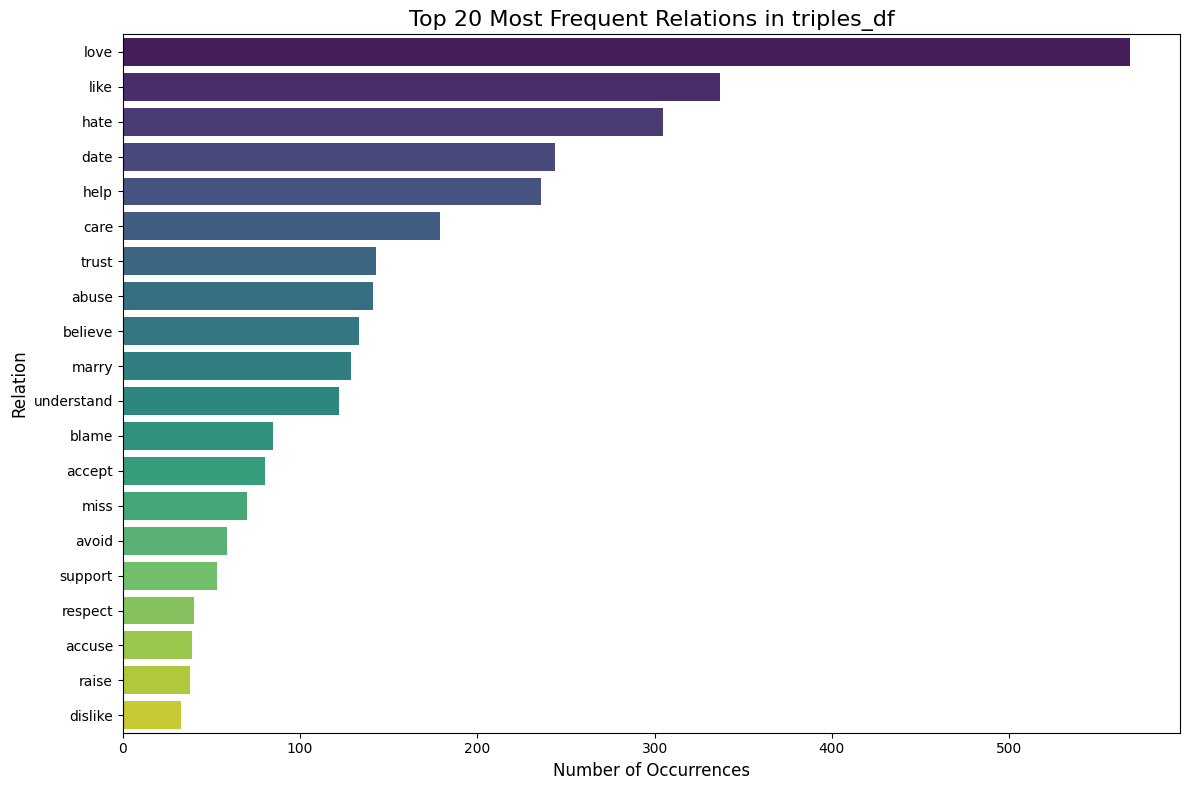

In [77]:
relation_counts = triples_df['relation'].value_counts()

sorted_relation_counts = relation_counts.sort_values(ascending=False)

top_20_relations = sorted_relation_counts.head(20)

# Visualize the statistics using a horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_relations.values, y=top_20_relations.index, orient='h', palette='viridis')
plt.title('Top 20 Most Frequent Relations in triples_df', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Relation', fontsize=12)
plt.tight_layout()
plt.show()

###  Print Sample Texts Based on Triple Count

In [82]:
# No triples extracted
print("\n No triples extracted:")
display(df3[df3["n_relationships"] == 0][["text", "resolved_text"]].sample(3))

# Exactly 1 triple
print("\n Exactly 1 triple:")
display(df3[df3["n_relationships"] == 1][["text", "resolved_text", "relationships"]].sample(3))

# More than 2 triples
print("\n Multiple triples:")
display(df3[df3["n_relationships"] >= 2][["text", "resolved_text", "relationships"]].sample(3))



 No triples extracted:


,text,resolved_text
1945,When someone tries to talk to me I get so nerv...,When someone tries to talk to me I get so nerv...
1539,From a teen in the US: My parents have been ha...,From a teen in the US: My parents have been ha...
4435,From the U.S.: My husband and I have been toge...,From the U.S.: My husband and I have been toge...



 Exactly 1 triple:


,text,resolved_text,relationships
2847,I think I like it too much,I think I like it too much,"[{'subject': 'I', 'relation': 'like', 'object'..."
3945,I’m 16 now and since I can remember I’ve been ...,I’m 16 now and since I can remember I’ve been ...,"[{'subject': 'I', 'relation': 'avoid', 'object..."
1792,My son is 8 years old He’s had serious problem...,My son is 8 years old He’s had serious problem...,"[{'subject': 'they', 'relation': 'help', 'obje..."



 Multiple triples:


,text,resolved_text,relationships
1881,I want to help my guy He was sexually abused a...,I want to help my guy He was sexually abused a...,"[{'subject': 'He', 'relation': 'abuse', 'objec..."
3724,I have been getting hit by my dad for as long ...,I have been getting hit by my dad for as long ...,"[{'subject': 'He', 'relation': 'abuse', 'objec..."
4371,"Hello, I am a 17 years old teenager, since I w...","Hello, I am a 17 years old teenager, since I w...","[{'subject': 'they', 'relation': 'like', 'obje..."


# Clustering Relationships by Verb Type (Using Embeddings + Clustering)

In [87]:
# Extract only unique verbs (relations) from the triples
triples_df["verb"] = triples_df["relation"].apply(lambda x: x if isinstance(x, str) else None)
# Rename the 'verb' column to 'relation'
triples_df = triples_df.rename(columns={'verb': 'relation_text'}) # Renaming to relation_text to avoid conflict with the original relation column

unique_verbs = sorted(triples_df["relation_text"].dropna().unique())
print(f"Found {len(unique_verbs)} unique verbs:", unique_verbs)

Found 42 unique verbs: ['abandon', 'abuse', 'accept', 'accuse', 'admire', 'avoid', 'befriend', 'believe', 'betray', 'blame', 'care', 'confide', 'connect', 'criticize', 'date', 'depend', 'despise', 'dislike', 'doubt', 'envy', 'fear', 'forgive', 'hate', 'help', 'like', 'love', 'marry', 'miss', 'neglect', 'open', 'parent', 'protect', 'raise', 'reject', 'relate', 'rely', 'resent', 'respect', 'support', 'teach', 'trust', 'understand']


In [88]:
triples_df = triples_df.rename(columns={'verb': 'relation'})
print(triples_df.head())

   id  text_id                                            context subject  \
0   0        1       Nobody likes me because I'm not interesting.  Nobody   
1   1        9   Nobody cares about me because they didn't ask...  Nobody   
2   2       10   My partner didn't say 'I love you' today our ...       I   
3   3       12   I didn't get a reply to my email they must ha...    they   
4   4       23      No one will ever love me because I'm too shy.     one   

  relation object  negated dominant_distortion secondary_distortion  \
0     like     me    False  General Distortion                  NaN   
1     care     me    False  General Distortion                  NaN   
2     love    you    False  General Distortion                  NaN   
3     hate     me    False  General Distortion                  NaN   
4     love     me    False  General Distortion                  NaN   

  relation_text  
0          like  
1          care  
2          love  
3          hate  
4          love  


#### Convert Verbs to Vectors Using Pretrained Model


In [89]:
nlp_lg = spacy.load("en_core_web_lg")
verb_vectors = np.array([nlp_lg(verb).vector for verb in unique_verbs])

#### Apply Clustering (KMeans)


In [90]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(verb_vectors)

# Map verbs to cluster IDs
verb_cluster_map = {verb: int(cluster) for verb, cluster in zip(unique_verbs, clusters)}

#### Visualizing Clusters

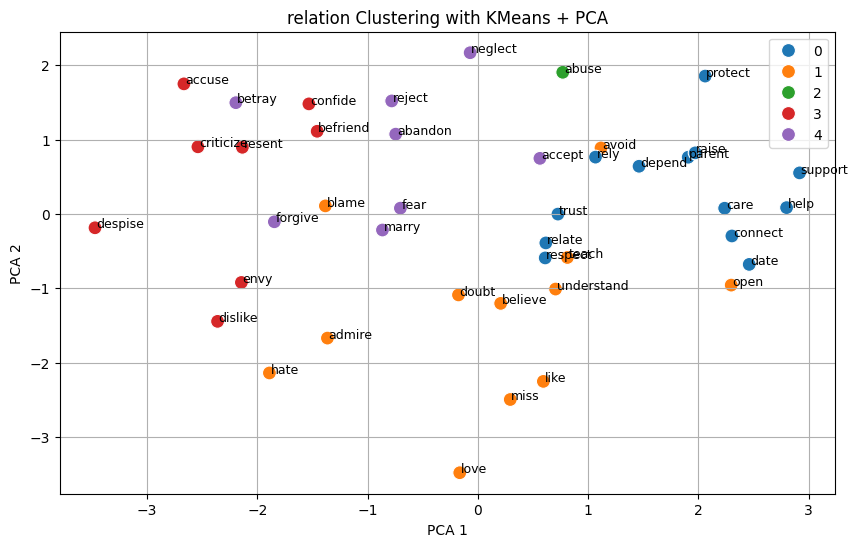

In [92]:
# Reduce dimensions for plotting
pca = PCA(n_components=2)
verb_vec_2d = pca.fit_transform(verb_vectors)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=verb_vec_2d[:, 0], y=verb_vec_2d[:, 1], hue=clusters, palette="tab10", s=100)

# Annotate points
for i, verb in enumerate(unique_verbs):
    plt.text(verb_vec_2d[i, 0] + 0.01, verb_vec_2d[i, 1], verb, fontsize=9)

plt.title("relation Clustering with KMeans + PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

#### mapping each verb to it cluster and return a list of verbs to each cluster

In [93]:
cluster_to_verbs = {}
for verb, cluster_id in verb_cluster_map.items():
    if cluster_id not in cluster_to_verbs:
        cluster_to_verbs[cluster_id] = []
    cluster_to_verbs[cluster_id].append(verb)

# Print the list of verbs for each cluster
print("\nRelations assigned to each cluster:")
for cluster_id, verbs_list in cluster_to_verbs.items():
    print(f"Cluster {cluster_id}: {verbs_list}")


Relations assigned to each cluster:
Cluster 4: ['abandon', 'accept', 'betray', 'fear', 'forgive', 'marry', 'neglect', 'reject']
Cluster 2: ['abuse']
Cluster 3: ['accuse', 'befriend', 'confide', 'criticize', 'despise', 'dislike', 'envy', 'resent']
Cluster 1: ['admire', 'avoid', 'believe', 'blame', 'doubt', 'hate', 'like', 'love', 'miss', 'open', 'teach', 'understand']
Cluster 0: ['care', 'connect', 'date', 'depend', 'help', 'parent', 'protect', 'raise', 'relate', 'rely', 'respect', 'support', 'trust']


#### mapping clusters to semantic categories

In [95]:
# Define manual labels based on cluster inspection
relation_cluster_labels = {
    0: "Supportive Trust",
    1: "Emotional Evaluation",
    2: "Harmful Actions",
    3: "Social Tension",
    4: "Bond Alteration"
}
# Add cluster label to each row in triples_df
triples_df["relation_cluster"] = triples_df["relation"].map(verb_cluster_map)
triples_df["relation_cluster_label"] = triples_df["relation_cluster"].map(verb_cluster_labels)

In [97]:
triples_df.head()

,id,text_id,context,subject,relation,object,negated,dominant_distortion,secondary_distortion,relation_text,relation_cluster,relation_cluster_label
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,False,General Distortion,NaN,like,1,Supportive Actions
1,1,9,Nobody cares about me because they didn't ask...,Nobody,care,me,False,General Distortion,NaN,care,0,Negative Affect / Conflict Emotion
2,2,10,My partner didn't say 'I love you' today our ...,I,love,you,False,General Distortion,NaN,love,1,Supportive Actions
3,3,12,I didn't get a reply to my email they must ha...,they,hate,me,False,General Distortion,NaN,hate,1,Supportive Actions
4,4,23,No one will ever love me because I'm too shy.,one,love,me,False,General Distortion,NaN,love,1,Supportive Actions


In [98]:
triples_df['Dominant Distortion'] = triples_df['text_id'].map(df3.set_index('id')['Dominant Distortion'])
triples_df['Secondary Distortion (Optional)'] = triples_df['text_id'].map(df3.set_index('id')['Secondary Distortion (Optional)'])

# Display the updated triples_df
print("Triples DataFrame with Distortion columns:")
display(triples_df.head())
print(len(triples_df))

Triples DataFrame with Distortion columns:


,id,text_id,context,subject,relation,object,negated,dominant_distortion,secondary_distortion,relation_text,relation_cluster,relation_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,Nobody,like,me,False,General Distortion,NaN,like,1,Supportive Actions,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,Nobody,care,me,False,General Distortion,NaN,care,0,Negative Affect / Conflict Emotion,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,I,love,you,False,General Distortion,NaN,love,1,Supportive Actions,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,they,hate,me,False,General Distortion,NaN,hate,1,Supportive Actions,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,one,love,me,False,General Distortion,NaN,love,1,Supportive Actions,General Distortion,NaN


3307


### Saving the result

In [99]:
# prompt: save triples_df in my drive in My Research folder
drive.mount('/content/drive')
triples_df.to_csv('/content/drive/My Drive/My Research/triples_df.csv', index=False)
print("triples_df saved to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
triples_df saved to Google Drive.


In [110]:
from google.colab import drive, files
import json
from github import Github
import os

# 1. Mount Drive (skip if already mounted)
try:
    drive.mount('/content/drive')
except:
    pass

# 2. Define paths
NOTEBOOK_PATH = "/content/drive/MyDrive/Colab Notebooks/Clustering_Relation_Verbs.ipynb"
CLEANED_PATH = "/content/Clustering_Relation_Verbs_CLEANED.ipynb"

# 3. Clean notebook while preserving outputs
with open(NOTEBOOK_PATH, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

if 'metadata' in notebook:
    notebook['metadata'].pop('widgets', None)
    if 'colab' in notebook['metadata']:
        notebook['metadata']['colab'].pop('widgets', None)

with open(CLEANED_PATH, 'w', encoding='utf-8') as f:
    json.dump(notebook, f)

# 4. Upload to GitHub
GITHUB_TOKEN = "ghp_your_token_here"  # Replace with your token
g = Github(GITHUB_TOKEN)
repo = g.get_repo("UBGidado/My_Research")
file_path = "Clustering_Relation_Verbs.ipynb"

try:
    # Check if file exists to get SHA
    try:
        existing_file = repo.get_contents(file_path)
        sha = existing_file.sha
        operation = repo.update_file
        message = "Updated notebook from Colab"
    except:
        sha = None
        operation = repo.create_file
        message = "Added notebook from Colab"

    with open(CLEANED_PATH, 'r') as f:
        content = f.read()

    operation(
        path=file_path,
        message=message,
        content=content,
        sha=sha
    )
    print("✅ Successfully uploaded to GitHub!")
except Exception as e:
    print(f"❌ Error: {str(e)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


GithubException: Invalid request.

"sha" wasn't supplied.: 422 {"message": "Invalid request.\n\n\"sha\" wasn't supplied.", "documentation_url": "https://docs.github.com/rest/repos/contents#create-or-update-file-contents", "status": "422"}